# Environment Setup

In [5]:
import torch
from torch.utils import data
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

##Data

In [6]:
class ExpDataset(Dataset):
  def __init__(self, data):
    assert data.size(dim=1) == 2
    self.data = data

  def __len__(self):
    return self.data.size(dim=0)

  def __getitem__(self, idx):
    return torch.tensor([self.data[idx][0]], dtype=torch.float32), torch.tensor([self.data[idx][1]], dtype=torch.float32)

In [7]:
def plot_data(data):
  df = pd.DataFrame(data=data,columns=['X','Y'])
  sns.scatterplot(data=df,x='X',y='Y',s=1)

def plot_loss(data):
  df = pd.DataFrame(data=data,columns=['epoch','loss'])
  sns.lineplot(data=df,x='epoch',y='loss')

Generate example data

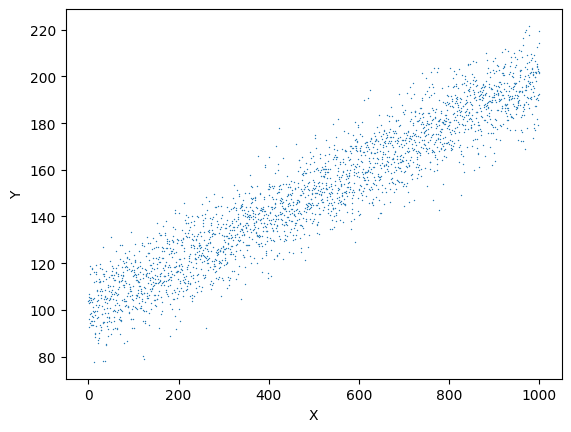

In [8]:
n = 2500
intercept = 100
slope = 0.1
rng = default_rng()
X = np.linspace(start=0,stop=1e3,num=n,dtype='float32')
Y = np.add(slope*X, intercept+rng.normal(loc=0, scale=10, size=n), dtype='float32')

data = np.stack((X,Y), 1)
plot_data(data)

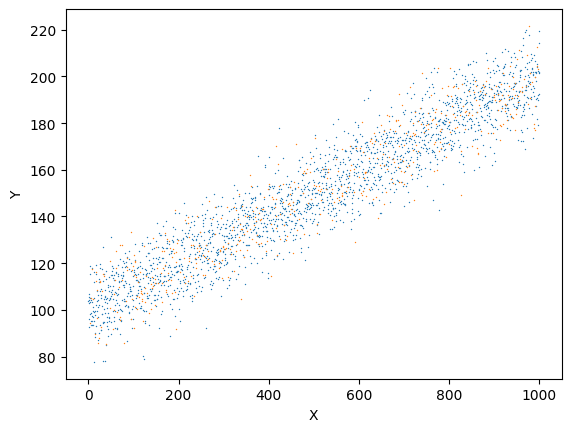

In [9]:
train_data, test_data = train_test_split(data,train_size=0.8)
plot_data(train_data)
plot_data(test_data)

In [10]:
batch_size = 512

training_data = ExpDataset(torch.from_numpy(train_data))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

testing_data = ExpDataset(torch.from_numpy(test_data))
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

Verify batching

In [11]:
for batch, (X, y) in enumerate(train_dataloader):
  X = X.detach().numpy()
  y = y.detach().numpy()
  print(f"Batch {batch}")
  print(f"X : {X.shape}")
  print(f"y : {y.shape}")
  print("-"*15)

Batch 0
X : (512, 1)
y : (512, 1)
---------------
Batch 1
X : (512, 1)
y : (512, 1)
---------------
Batch 2
X : (512, 1)
y : (512, 1)
---------------
Batch 3
X : (464, 1)
y : (464, 1)
---------------


##Model Definition

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cpu device


In [13]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(1, 1)

  def forward(self, x):
    return self.linear(x)

  def weight(self):
    return self.linear.weight.item()
  
  def bias(self):
    return self.linear.bias.item()


In [42]:
model = LinearRegression().to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [43]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Model Training

In [44]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  epoch_loss = []
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #Forward pass
    pred = model(X)

    # Compute prediction error
    loss = loss_fn(pred, y)
    epoch_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

Epoch 1 | loss: 100672.3046875
Epoch 5000 | loss: 1823.7812194824219
Epoch 10000 | loss: 1103.0321197509766
Epoch 15000 | loss: 579.4890899658203
Epoch 20000 | loss: 249.25283813476562
Epoch 25000 | loss: 108.9040584564209
Epoch 30000 | loss: 100.13075065612793
Epoch 35000 | loss: 100.34283638000488
Epoch 40000 | loss: 100.51424598693848
Epoch 45000 | loss: 100.20959281921387
Epoch 50000 | loss: 100.2289810180664
Done!


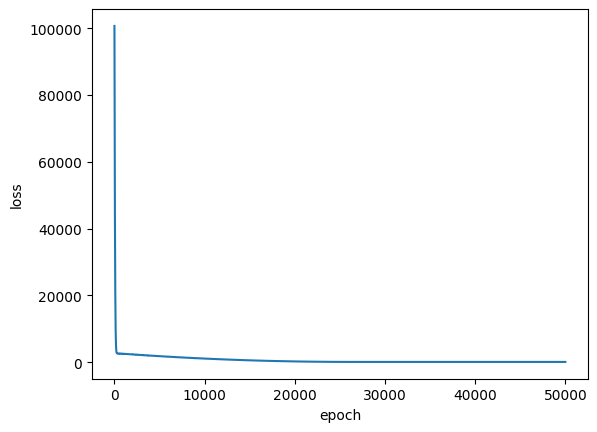

In [45]:
epochs = 50000
print_every_n = 5000

loss_curve = []
for t in range(epochs):
  epoch_loss = train(train_dataloader, model, loss_fn, optimizer)
  loss_curve.append([t+1,epoch_loss])
  # Print the first epoch metric and then print_every_n epochs
  if t==0 or (t+1)%print_every_n == 0:
    print(f"Epoch {t+1} | loss: {epoch_loss}")
print("Done!")
loss_curve = np.asarray(loss_curve, dtype=np.float32)
plot_loss(loss_curve)

Trained Parameters

In [46]:
print(f"Slope: {model.weight()}")
print(f"Intercept: {model.bias()}")

Slope: 0.10031421482563019
Intercept: 99.7535171508789


Model Prediction

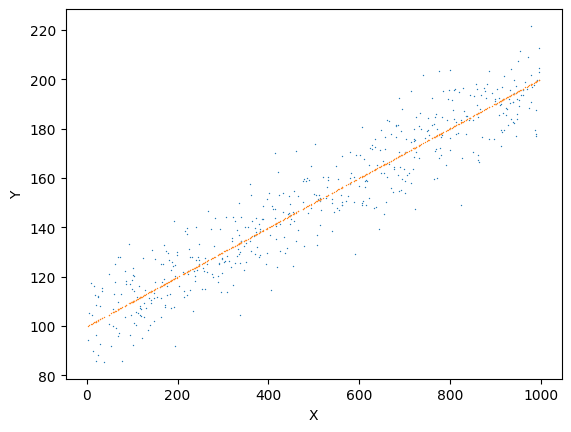

In [47]:
for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    #Forward pass
    pred = model(X)
    pred = pred.detach().numpy()

    #Compare
    target_data = torch.stack((X,y),dim=1)
    target_data = torch.squeeze(target_data)
    predicted_data = torch.stack((X,torch.from_numpy(pred)),dim=1)
    predicted_data = torch.squeeze(predicted_data)
    plot_data(target_data)
    plot_data(predicted_data)